# 1. Solution of Tutorial-1

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Global variables
global MSUN,  PC, PI, COS

# Solar Mass in seconds
# GM/C^3
MSUN = 4.925491025543575903411922162094833998e-6

# One Parsec in seconds
MPC = 1.0292712503e14

# PI
PI = np.pi

# COS
COS = np.cos

In [0]:
def td_newtonian_chirp(m1, m2, fnot, phi_not, distance, time_range):
    """
    Compute time domain newtonian chirp h(t)
    Parameters
    ----------
    m1: float
        Mass of the compact object 1
    m2: float
        Mass of the compact object 2
    fnot: float
          Startig frequency of the Signal
    phi_not: float
             Phase at some time.
    distance: float
              Luminosity distance D to the source
    time_range: array-like
                Time array of the signal in sec
    Return
    ------
    td_nchirp: array-like
               Time domain Newtonian chirp h(t)
    idx: array-like
         Indices required for plotting
    """
    
    # Scaling
    m1 *= MSUN
    m2 *= MSUN
    distance *= MPC
    
    # Total Mass
    Total_mass = m1 + m2
    
    # Reduced Mass
    Reduced_mass = m1 * m2 / Total_mass
    
    # Chirp Mass
    Chirp_mass = Reduced_mass**(3./5.) * Total_mass**(2./5.)

    # Coalescence time
    tc = 5. / (256. * (PI * fnot)**(8./3.) * Chirp_mass**(5./3.))

    # Index of time range, where coalescence time is greater than the time range
    idx = time_range < tc 
    # Coalescence time duration
    tc_array = time_range[idx]
    # Initialize time domain Newtonian chirp array
    td_nchirp = np.zeros(len(time_range))
    # Duration of Coalescence time
    tc_duration = tc
    # Reassign the coalescence duration time into coalescence array
    tc = tc_array

    # Frequency evolution
    freq_evol = (Chirp_mass * fnot**9.) ** (1./8.)
    freq_evol /= ((Chirp_mass * fnot)**(1./3.) - 256. * fnot**3. * Chirp_mass**2. * PI**(8./3.) * tc_array / 5.) ** (3./8.)

    # Amplitude
    amplitude = (4. * Chirp_mass**(5./3.) * PI**(2./3.) * freq_evol**(2./3.)) / distance

    # Phase
    phase = phi_not - 2. * (1./(256. * (PI*Chirp_mass*fnot) ** (8./3.)) - tc_array / (5. * Chirp_mass)) ** (5./8.)

    # Time domain Newtonian chirp
    td_nchirp[idx] = amplitude * COS(phase)

    # ----------------------------------------------------------------------- #
    # ----------------------------------------------------------------------- #
    print("------------------------------------------------------------------")
    print(" Chirp Mass (Solar Mass sec)             :", Chirp_mass)
    print(" Coalescence time (sec)                  :", tc_duration)
    print(" Frequency evolution - First data point  :", freq_evol[0]) 
    print(" Amplitude - First data point            :", amplitude[0])
    print(" Phase - First data point                :", phase[0])
    print(" TD Newtonian chirp - First data point   :", td_nchirp[0])
    print("------------------------------------------------------------------")

    return td_nchirp, idx

---

# 2. Simple Matched Filter
Let us construct a simple matched filter (non-optimal) by simply cross-correlating the noisy data - which has the GW signal deeply embedded in it - with a template.

## 2.1 Cross correlation
The cross correlation function $R(\tau)$ for two time series vectors $f(t)$ and $\hat{h}(t)$ for a time shift $\tau$ is defined as,

$$ R(\tau) = \int_{-\infty}^{\infty} f(t) * \hat{h}^*(t-\tau)\ dt. $$

Here, $^*$ denotes the complex conjugate and the normalized template vector $\hat{h} = \frac{h}{||h||}$. If $\sigma^2$ is the variance of noise then the norm $||h||$ is defined as,

$$ ||h||^2 = \int_0^{t_c} \frac{|h(t)|^2}{\sigma^2}\ dt. $$

---

<center><u><b><h1> Task </center></u></b></h1>

Create a Gaussian noise vector and inject the GW template in it at t = 6 sec. Cross correlate this data with the normalized template. Plot the cross correlation.

---

In [0]:
# Duration of the signal
tduration = 16
Fs = 4096
sigma = 5e-21

# create a time vector 
time_array = np.arange(0, tduration, 1./Fs)

# Time Domain Newtonian Chirp Signal
chirp, index =td_newtonian_chirp(m1= 20, m2=10, fnot=30, phi_not=0, distance=100, time_range=time_array)

# create noise vector
noise = np.random.normal(scale=sigma, size=time_array.shape)

# get a data vector by adding the template in noise vector at t = 6 sec
data = noise.copy()
data[6*Fs : 6*Fs+len(chirp[index])] += chirp[index]

------------------------------------------------------------------
 Chirp Mass (Solar Mass sec)             : 5.9929862125114186e-05
 Coalescence time (sec)                  : 1.1568265168522474
 Frequency evolution - First data point  : 30.0
 Amplitude - First data point            : 7.386687025877906e-22
 Phase - First data point                : -348.8906579348046
 TD Newtonian chirp - First data point   : -7.275311050366607e-22
------------------------------------------------------------------


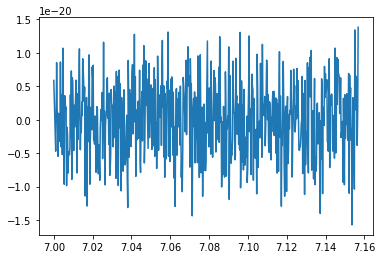

In [0]:
plt.plot(time_array[int(7*Fs) : 6*Fs+len(chirp[index])], data[int(7*Fs) : 6*Fs+len(chirp[index])])

In [0]:
# initialize the cross correlation vector
R_tau = np.zeros(tduration*Fs)

# cyclically shifting the chirp to get the peak in SNR at the location of GW merger
shifted_chirp = np.roll(chirp, -len(chirp[index]))

# Calculating the norm
norm = abs(chirp[index])**2./sigma**2.
norm = norm.sum()
norm **= 0.5

print('SNR of GW signal: ', norm)

# Weighing the shifted_chirp to get template
template = shifted_chirp / norm

SNR of GW signal:  10.148147261087084


In [0]:
# for each step 'i' in time slide
for i in range(tduration*Fs):
    R_tau[i] = (data*np.roll(template, i)).sum()

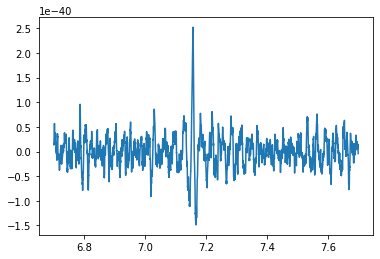

In [0]:
t_0 = 7.2
width = 0.5
id_s = int((t_0-width)*Fs)
id_e = int((t_0+width)*Fs)
plt.plot(time_array[id_s:id_e], R_tau[id_s:id_e])